# Replication - Schematic Figure

Here we provide a notebook to replicate the schematic figure.

The notebook replicates the results in:
- /out/simulation/figures/schematic.eps

The main script can be found at: 
- /scripts/simulation/figures/schematic.py



In [1]:
!pip3 install probcox 

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 607 kB 5.2 MB/s 
  Created wheel for probcox: filename=probcox-0.0.5-py3-none-any.whl size=5224 sha256=e3e97fd12bf617d795ea8e64a5e86d8fb558e7b30ec405c70c15301de84f84a1
  Stored in directory: /root/.cache/pip/wheels/7b/6c/69/1adac1abb2e1e8c9d58200fa7a181920d2f7c90809c837d47a
Successfully built probcox


In [2]:
# Modules
# =======================================================================================================================
import os
import sys
import shutil
import subprocess
import tqdm

import numpy as np
import pandas as pd

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import probcox as pcox

dtype = torch.FloatTensor


np.random.seed(5256)
torch.manual_seed(9235)

In [3]:
# Functions
# =======================================================================================================================
def forward_fill(x):
    for ii in range(1, x.shape[0]):
        if np.sum(x[ii, :]) == 0:
            x[ii, :] = x[ii-1, :]
    return(x)

def logisitc(x):
    return(1/(1+np.exp(-x)))

def logit(x):
    return(np.log(x/(1-x)))

In [4]:

# Plot Settings
# =======================================================================================================================
plt.rcParams['font.size'] = 7
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
cm = 1/2.54


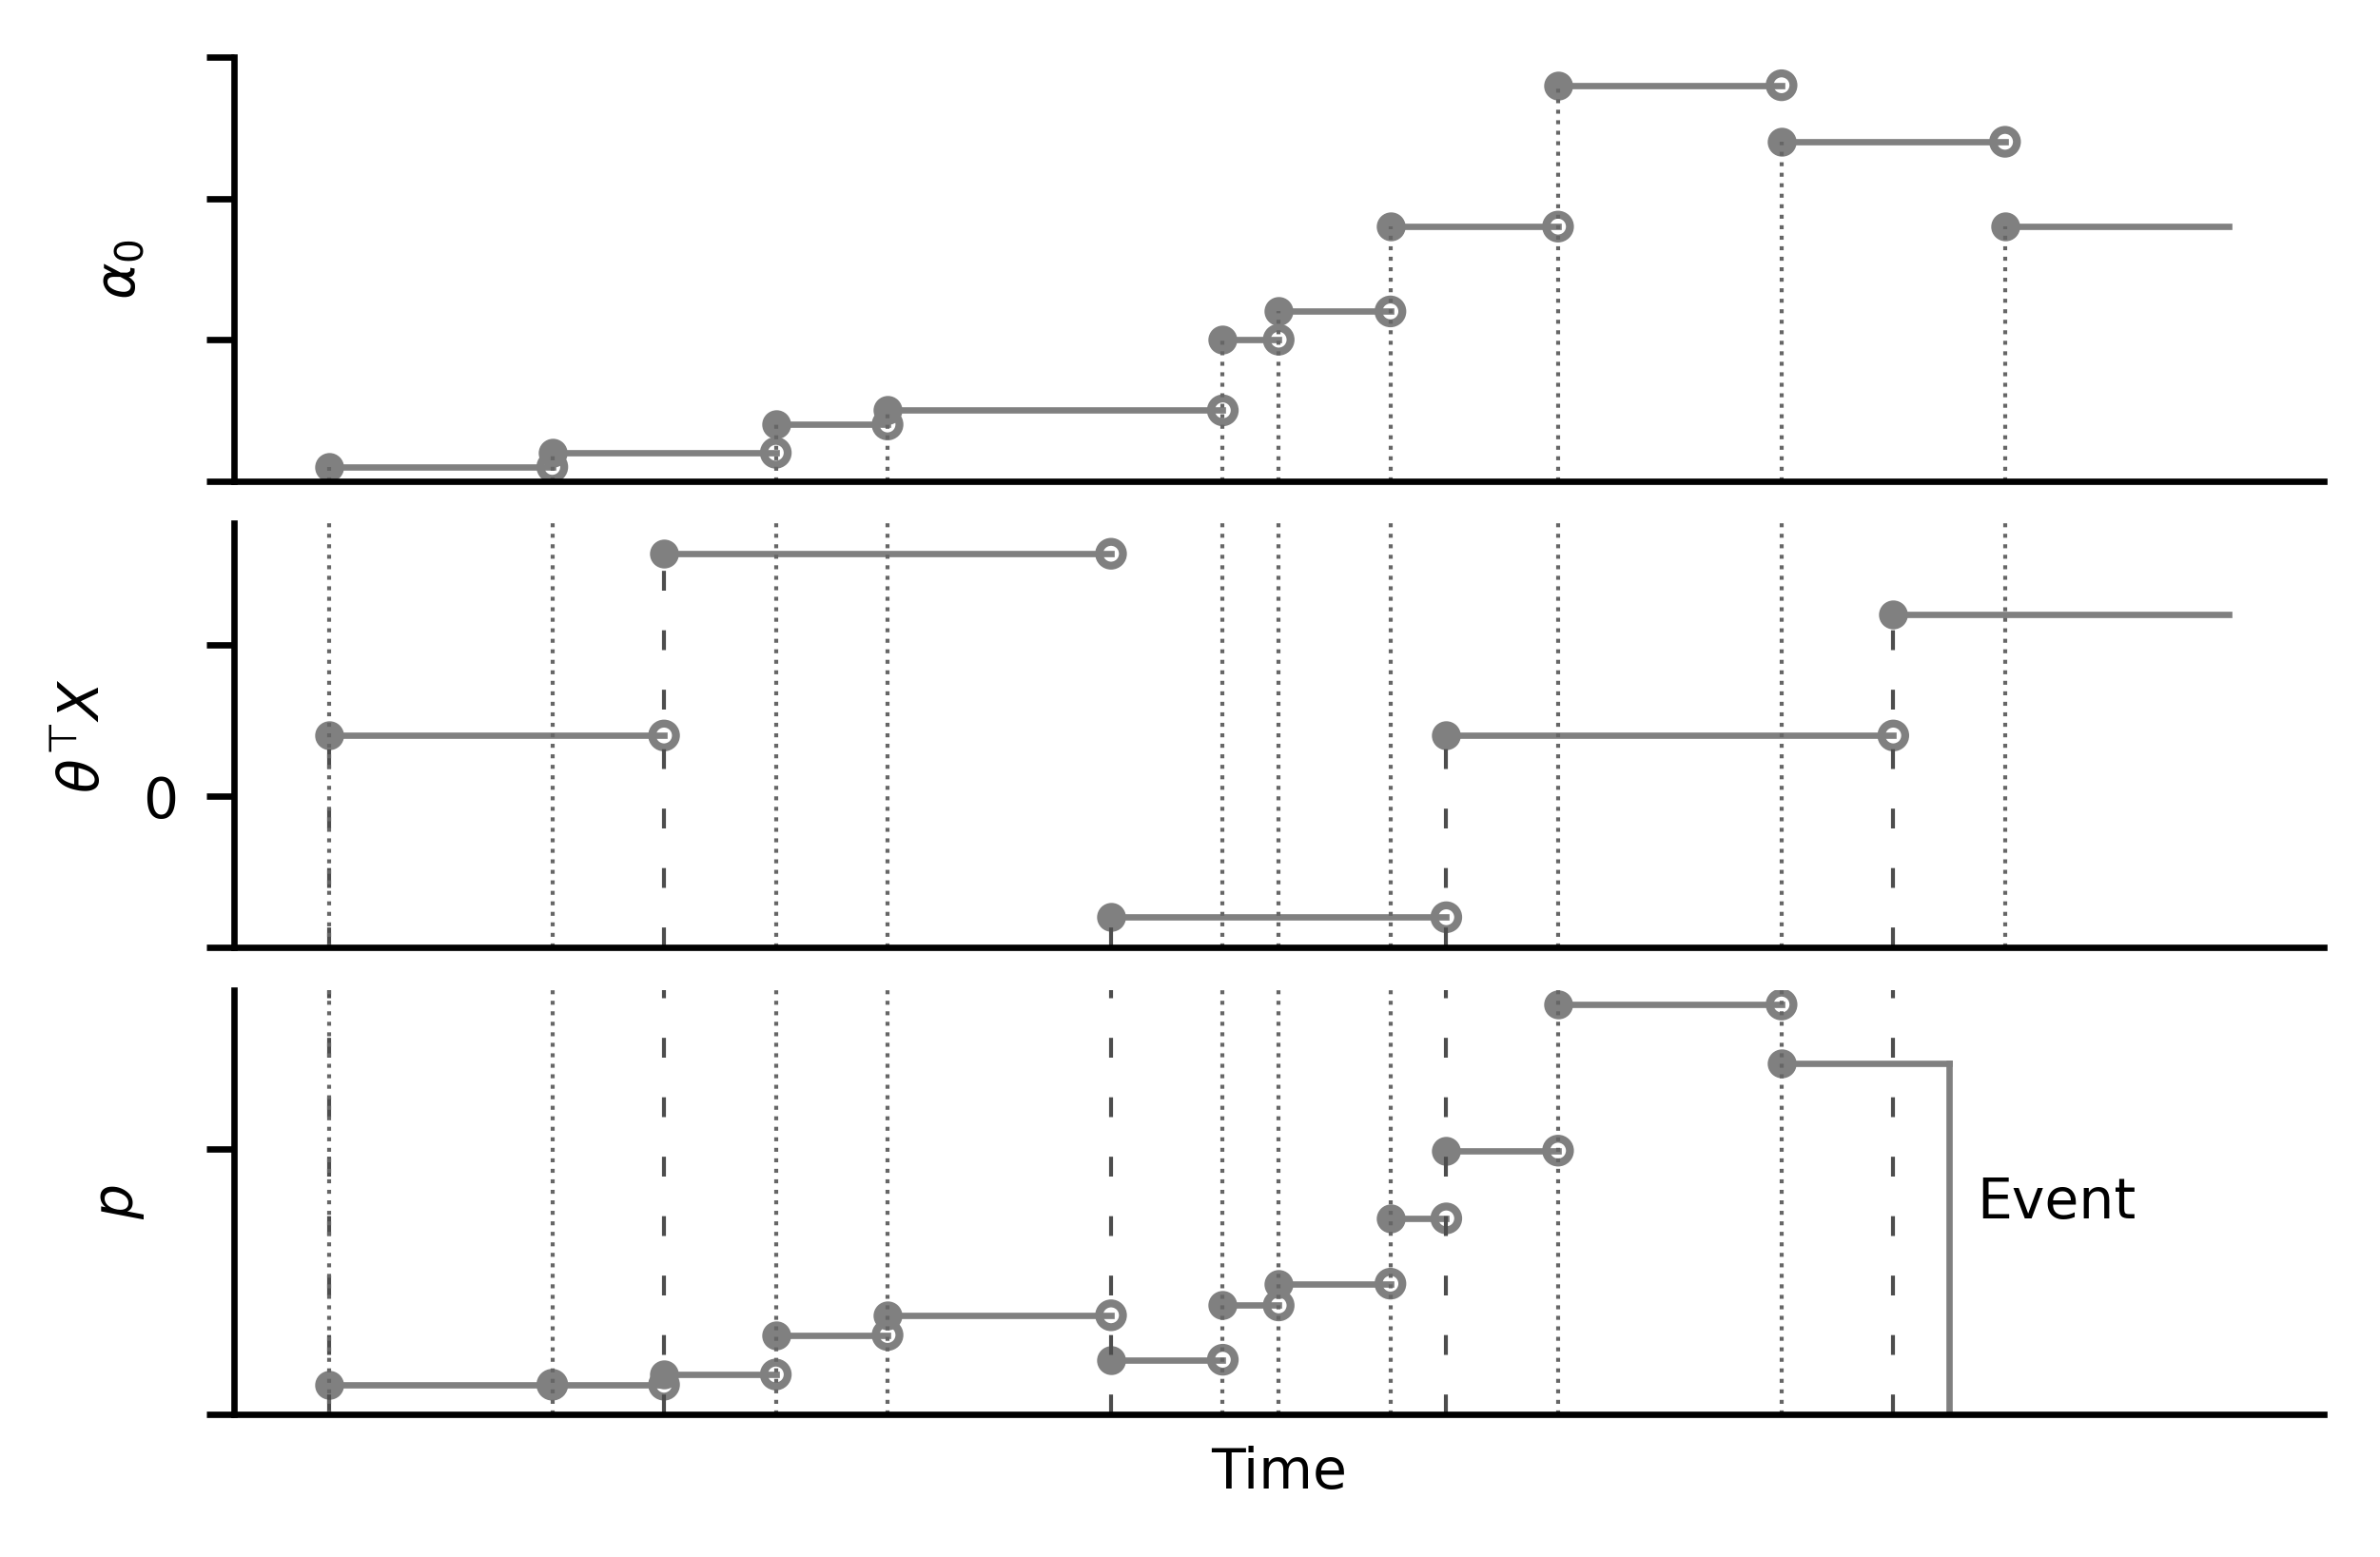

In [5]:

fig, ax = plt.subplots(3, 1, figsize=(12*cm, 8*cm), dpi=600, sharex=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)

tlambda0 = np.asarray([0, 200, 400, 500, 800, 850, 950, 1100, 1300, 1500, 1700])
lambda0 = np.asarray([5, 10, 20, 25, 50, 60, 90, 140, 120, 90, 50])/10000

for ii in range(10):
    ax[0].plot([tlambda0[ii], tlambda0[ii+1]], [lambda0[ii], lambda0[ii]], c='.5', linewidth=0.8)
    if ii < 9:
        ax[0].scatter(tlambda0[ii+1], lambda0[ii], s=9, facecolors='none', edgecolors='.5')
    ax[0].scatter(tlambda0[ii], lambda0[ii], s=7, c='.5')
    ax[0].axvline(tlambda0[ii], ymin=0, ymax=lambda0[ii]/0.015, c='.4', ls=':', linewidth=0.5)
ax[0].set_ylim(0, 0.015)
ax[0].set_ylabel(r'$\alpha_0$')
ax[0].set_yticklabels([])


tx = np.asarray([0, 300, 700, 1000, 1400, 1700])
x = np.asarray([0.1, 0.4, -0.2, 0.1, 0.3, 0.2])
for ii in range(5):
    ax[1].plot([tx[ii], tx[ii+1]], [x[ii], x[ii]], c='.5', linewidth=0.8)
    if ii < 4:
        ax[1].scatter(tx[ii+1], x[ii], s=9, facecolors='none', edgecolors='.5')
    ax[1].scatter(tx[ii], x[ii], s=7, c='.5')
    ax[1].axvline(tx[ii], ymin=0, ymax=(x[ii]+0.25)/0.7, c='.3', ls=(0, (5, 10)), linewidth=0.5)
for ii in range(10):
    ax[1].axvline(tlambda0[ii], c='.4', ls=':', linewidth=0.5)

ax[1].set_ylim(-0.25, 0.45)
ax[1].set_ylabel(r'$\theta^{\top} X$')
ax[1].set_yticklabels(['', '0', ''])

basehaz = np.copy(lambda0)[:, None]
t_lambda0 = np.copy(tlambda0)
X = np.copy(x)[:, None]
t_cov= np.copy(tx)

#expand
basehaz = np.concatenate((basehaz, np.zeros((t_cov.shape[0], 1))))
X = np.concatenate((np.zeros((t_lambda0.shape[0], 1)), X))
t = np.concatenate((t_lambda0, t_cov))
idx_sort = np.argsort(t)
t = t[idx_sort]
basehaz = forward_fill(basehaz[idx_sort])
X = forward_fill(X[idx_sort])

# collapse
X = np.concatenate([np.sum(X[t==ii, :], axis=0)[None, :] for ii in np.unique(t)])
basehaz = np.concatenate([np.sum(basehaz[t==ii, :], axis=0)[None, :] for ii in np.unique(t)])
t = np.unique(t)
t
# artifical event
t = t[:-2]
t[-1] = 1450

# survial data
H = logisitc(X + logit(basehaz))
for ii in range(12):
    ax[2].plot([t[ii], t[ii+1]], [H[ii], H[ii]], c='.5', linewidth=0.8)
    if ii != 11:
        ax[2].scatter(t[ii+1], H[ii], s=9, facecolors='none', edgecolors='.5')
    ax[2].scatter(t[ii], H[ii], s=7, c='.5')
for ii in range(5):
    ax[2].axvline(tx[ii], c='.3', ls=(0, (5, 10)), linewidth=0.5)
for ii in range(9):
    ax[2].axvline(tlambda0[ii], c='.4', ls=':', linewidth=0.5)

ax[2].axvline(t[12], ymin=0, ymax=H[11]/0.016, c='.5', ls='-', linewidth=0.8)
ax[2].text(1475, 0.0074, 'Event')
ax[2].set_ylim(0.0, 0.016)
ax[2].set_ylabel(r'$p$')
ax[2].set_xlabel('Time')
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_xticks([])


plt.show()
#plt.savefig('./out/simulation/figures/schematic.eps', bbox_inches='tight', dpi=600, transparent=True)
#plt.savefig('./out/simulation/figures/schematic.png', bbox_inches='tight', dpi=600, transparent=True)
#plt.savefig('./out/simulation/figures/schematic.pdf', bbox_inches='tight', dpi=600, transparent=True)
plt.close()